In [178]:
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
from pytz import timezone, utc
from timezonefinder import TimezoneFinder
import geopy.distance
import matplotlib.pyplot as plt
import math

plt.rcParams['font.size'] = '20'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 999)


# AIR TRAVEL (March 2015-)

In [179]:
ROOT_DIR = '/Users/alexanderguo/Desktop/picrazy2.github.io/flightlog/'
df = pd.read_csv(ROOT_DIR + 'flightlog.csv')
airports = pd.read_csv(ROOT_DIR + 'airports.csv')

tf = TimezoneFinder()

def get_offset(t, lat, lng):
    """
    returns a location's time zone offset from UTC in hours.
    """
    tz_target = timezone(tf.certain_timezone_at(lng=lng, lat=lat))
    today_target = tz_target.localize(t)
    today_utc = utc.localize(t)
    return (today_utc - today_target).total_seconds() / 3600

def get_offset_tz(t, tz_target):
    """
    returns a location's time zone offset from UTC in hours.
    """
    today_target = tz_target.localize(t)
    today_utc = utc.localize(t)
    return (today_utc - today_target).total_seconds() / 3600


In [180]:
# Main Processing

df['Date'] = pd.to_datetime(df['Date'])

df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], left_on='Dep Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'Lat': 'Dep Lat', 'Long': 'Dep Long', 'City': 'Dep City', 'Country': 'Dep Country'})
df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], left_on='Arr Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'Lat': 'Arr Lat', 'Long': 'Arr Long', 'City': 'Arr City', 'Country': 'Arr Country'})

df['Distance'] = df.apply(lambda row: geopy.distance.distance((row['Dep Lat'], row['Dep Long']), (row['Arr Lat'], row['Arr Long'])).miles, axis=1)
df['Duration'] = df.apply(lambda row: np.sum(np.multiply(np.array([int(x) for x in row['Actual Duration'].split(':')]), np.array([60, 1]))) if isinstance(row['Actual Duration'], str) else 0, axis=1)

ALL_TIME_COLS = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Scheduled Duration', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)', 'Actual Duration']
DATETIME_COLS = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)']
important_cols = ['Date', 'Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Duration', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Distance', 'Dep Delay', 'Arr Delay', 'Class', 'Aircraft', 'Registration']


### Code to fix times below, it's not very clean ####
# format the time cols
for col in ALL_TIME_COLS:
    df[col] = pd.to_datetime(df[col]).dt.time
    if col in DATETIME_COLS:
        temp_col = df['Date'].astype(str)+' '+df[col].astype(str)
        temp_col = temp_col.replace('.*NaT', '', regex=True)
        df[col] = pd.to_datetime(temp_col)

# get timezones
df['Dep Timezone'] = df[['Dep Lat', 'Dep Long']].apply(lambda r: timezone(tf.certain_timezone_at(lng=r['Dep Long'], lat=r['Dep Lat'])), axis=1)
df['Arr Timezone'] = df[['Arr Lat', 'Arr Long']].apply(lambda r: timezone(tf.certain_timezone_at(lng=r['Arr Long'], lat=r['Arr Lat'])), axis=1)

# fill in UTC
for col in DATETIME_COLS:
    new_col = col.split('(')[0] + '(UTC)'
    deparr = 'Dep' if 'Dep' in col else 'Arr'
    for i, r in df.iterrows():
        if str(r[col]) != 'NaT':
            df.loc[i, new_col] = r[col]-timedelta(hours=get_offset(datetime.datetime.strptime(r[col].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), r[deparr + ' Lat'], r[deparr + ' Long']))
    
# get calculated flght times
for time_type in ['Scheduled', 'Actual']:
    df[time_type + ' difference'] = df[time_type + ' Arr Time (UTC)'] - df[time_type + ' Dep Time (UTC)']


# adjust dep/arr times, calculate delay
temp = pd.DataFrame()
for i, r in df.iterrows():
    for time_type in ['Scheduled', 'Actual']:
        if str(r[time_type + ' difference']) != 'NaT' and r[time_type + ' difference'].days < 0:
            r[time_type + ' Arr Time (UTC)'] = r[time_type + ' Arr Time (UTC)'] + timedelta(days=1)
    dep_delay = r['Actual Dep Time (UTC)'] - r['Scheduled Dep Time (UTC)']
    if dep_delay.days < 0 and dep_delay.seconds < 86400-3600: # can't have actual dep more than 1 hour before scheduled
        r['Actual Dep Time (UTC)'] = r['Actual Dep Time (UTC)'] + timedelta(days=1)
        r['Actual Arr Time (UTC)'] = r['Actual Arr Time (UTC)'] + timedelta(days=1)
    dep_delay = r['Actual Dep Time (UTC)'] - r['Scheduled Dep Time (UTC)']
    arr_delay = r['Actual Arr Time (UTC)'] - r['Scheduled Arr Time (UTC)']
    r['Dep Delay'] = np.nan if str(dep_delay) == 'NaT' else dep_delay.seconds//60 if dep_delay.days >= 0 else dep_delay.seconds//60-1440
    r['Arr Delay'] = np.nan if str(arr_delay) == 'NaT' else arr_delay.seconds//60 if arr_delay.days >= 0 else arr_delay.seconds//60-1440

    for time_type in ['Scheduled', 'Actual']:
        if str(r[time_type + ' Dep Time (Local)']) != 'NaT':
            r[time_type + ' Dep Time (Local)'] = r[time_type + ' Dep Time (UTC)'] + timedelta(hours=get_offset_tz(datetime.datetime.strptime(r[time_type + ' Dep Time (Local)'].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), r['Dep Timezone']))
        if str(r[time_type + ' Arr Time (Local)']) != 'NaT':    
            r[time_type + ' Arr Time (Local)'] = r[time_type + ' Arr Time (UTC)'] + timedelta(hours=get_offset_tz(datetime.datetime.strptime(r[time_type + ' Arr Time (Local)'].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), r['Arr Timezone']))
    
    if i > 0:
        r['Time since last flight'] = r['Actual Dep Time (UTC)'] - df.loc[i-1, 'Actual Arr Time (UTC)']
        r['Last flight arrival (UTC)'] = df.loc[i-1, 'Actual Arr Time (UTC)']
    temp = temp.append(r)
    
df = temp
df = df.drop(columns = ['Actual difference', 'Scheduled difference'])


TOTAL_DIST = df['Distance'].sum()
TOTAL_TIME = df['Duration'].sum()
NUM_FLIGHTS = df['Date'].count()
NUM_AIRLINES = df['Airline'].nunique()
NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))
sorted_by_flight_interval = df.sort_values('Time since last flight', ascending=False).reset_index()
LONGEST_INTERVAL = str(sorted_by_flight_interval.loc[0, 'Time since last flight'])
LONGEST_INTERVAL_0 = str(sorted_by_flight_interval.loc[0, 'Last flight arrival (UTC)'].date())
LONGEST_INTERVAL_1 = str(sorted_by_flight_interval.loc[0, 'Scheduled Dep Time (UTC)'].date())


print('Total Distance Flown (miles): ' + str(TOTAL_DIST))
print('Total time in the air: ' + str(timedelta(minutes=int(TOTAL_TIME))))
print('Total Flights: ' + str(NUM_FLIGHTS))
print('Number of Airlines: ' + str(NUM_AIRLINES))
print('Number of Countries: ' + str(NUM_COUNTRIES))
print('Number of Airports: ' + str(NUM_AIRPORTS))
print('Longest time without flying: ' + LONGEST_INTERVAL + ', ' + LONGEST_INTERVAL_0 + ' to ' + LONGEST_INTERVAL_1)

# df

Total Distance Flown (miles): 447171.1344914059
Total time in the air: 37 days, 23:33:00
Total Flights: 201
Number of Airlines: 28
Number of Countries: 27
Number of Airports: 74
Longest time without flying: 157 days 18:22:00, 2016-07-10 to 2016-12-15


# FLIGHTS SORTED BY DISTANCE

,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Distance,Dep Delay,Arr Delay,Class,Aircraft,Registration
64,2017-11-13,2017-11-13 06:00:00,2017-11-13 07:03:00,00:29:00,Delta,DL3854,PHL,JFK,93.709017,27.0,-7.0,Economy,CRJ9,N936XJ
57,2017-09-22,2017-09-22 08:30:00,2017-09-22 09:32:00,00:33:00,United,UA6071,IAD,PHL,134.682407,10.0,-19.0,Economy,CRJ7,N507MJ
193,2022-01-03,2022-01-03 18:10:00,2022-01-03 19:10:00,00:31:00,United,UA1778,IAH,AUS,140.223208,17.0,-12.0,Business,B737,N16732
29,2016-12-23,2016-12-23 21:45:00,2016-12-23 22:50:00,00:43:00,Silkair,MI341,KUL,SIN,184.712792,7.0,-15.0,Economy,A319,9VSBE
65,2017-11-13,2017-11-13 09:00:00,2017-11-13 10:24:00,00:41:00,Delta,DL4010,JFK,BOS,186.718871,25.0,-18.0,Economy,CRJ9,N907XJ
107,2019-06-01,2019-06-01 16:10:00,2019-06-01 17:15:00,00:53:00,Sichuan,3U8818,LJG,KMG,199.275720,5.0,-8.0,Economy,A319,B6442
0,2015-03-08,2015-03-08 08:34:00,2015-03-08 10:01:00,00:50:00,United,UA1711,BOS,EWR,200.540719,18.0,-19.0,Business,B738,N54241
34,2017-03-11,2017-03-11 07:06:00,2017-03-11 08:30:00,00:47:00,United,UA1548,BOS,EWR,200.540719,45.0,8.0,Economy,B739,N67827
37,2017-03-20,2017-03-20 21:52:00,2017-03-20 23:05:00,00:37:00,United,UA1775,EWR,BOS,200.540719,27.0,-9.0,Business,B739,N64809
117,2019-09-28,2019-09-28 20:30:00,2019-09-28 21:47:00,00:41:00,United,UA421,EWR,BOS,200.540719,18.0,-18.0,Economy,B739,N66808


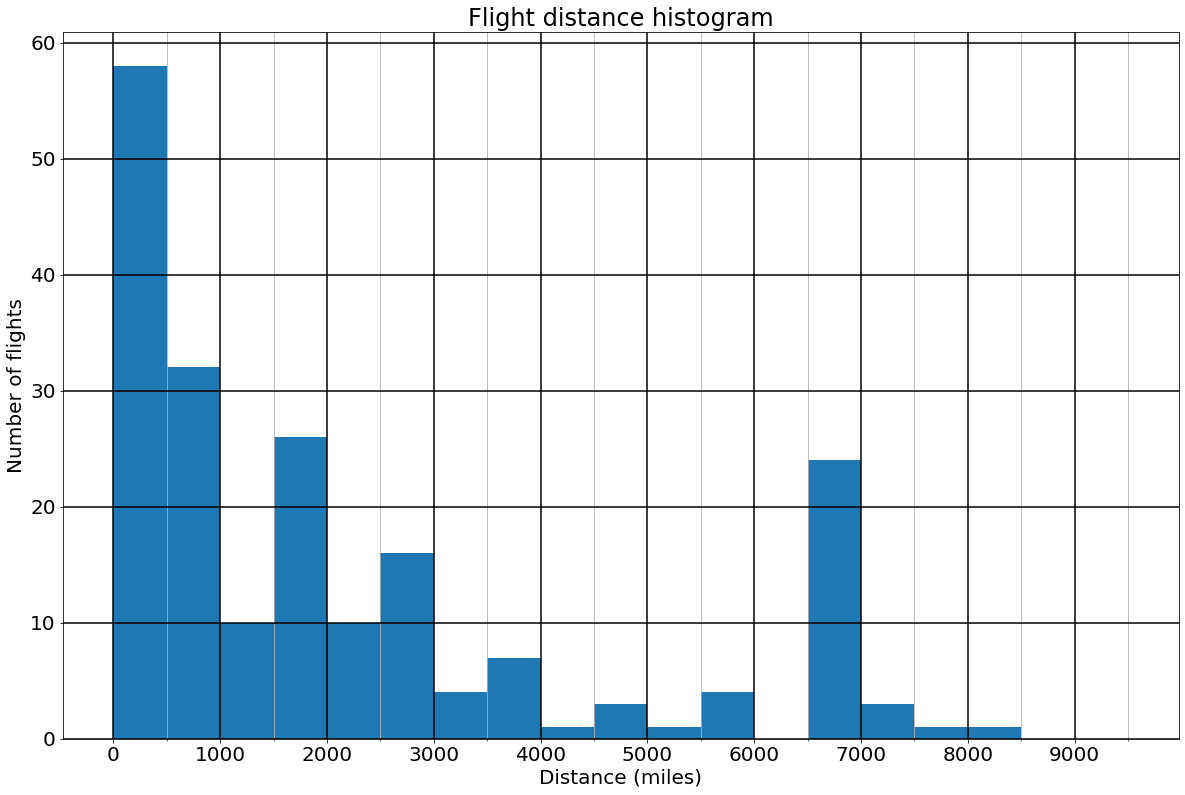

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(20,13))
bins = list(range(0, 10000, 500))
ax.hist(df['Distance'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if i%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Number of flights')
ax.set_title('Flight distance histogram')
plt.savefig('figures/distance_hist.jpg', bbox_inches='tight')

df.sort_values(['Distance'], ascending=True).head(10)[important_cols]


# FLIGHTS SORTED BY DURATION

,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Distance,Dep Delay,Arr Delay,Class,Aircraft,Registration
71,2018-01-07,2018-01-07 10:00:00,2018-01-07 08:40:00,14:09:00,United,UA2,SIN,SFO,8446.305238,20.0,-11.0,Business,B789,N38955
74,2018-03-29,2018-03-29 12:25:00,2018-03-29 14:35:00,14:03:00,Hainan,HU7961,PVG,BOS,7307.683803,26.0,19.0,Economy,B789,B7835
73,2018-03-22,2018-03-22 16:35:00,2018-03-23 19:20:00,14:03:00,Hainan,HU7962,BOS,PVG,7307.683803,14.0,-28.0,Economy,B788,B2750
97,2019-01-06,2019-01-06 23:55:00,2019-01-07 05:05:00,13:50:00,Air Canada,AC57,DXB,YYZ,6899.002047,74.0,54.0,Business,B77W,CFRAM
125,2019-12-18,2019-12-18 20:30:00,2019-12-19 18:00:00,13:34:00,United,UA1122,EWR,CPT,7816.760114,134.0,77.0,Business,B789,N27957
1,2015-03-08,2015-03-08 12:55:00,2015-03-09 15:00:00,13:30:00,United,UA89,EWR,PEK,6830.922824,45.0,10.0,Economy,B772,N78005
20,2016-06-05,2016-06-05 17:10:00,2016-06-06 19:05:00,13:29:00,Hainan,HU482,BOS,PEK,6736.622183,9.0,-17.0,Economy,B788,B2730
12,2016-03-13,2016-03-13 16:50:00,2016-03-14 19:05:00,13:26:00,Hainan,HU482,BOS,PEK,6736.622183,8.0,-41.0,Business,B788,B2731
7,2015-12-18,2015-12-18 12:00:00,2015-12-19 15:00:00,13:22:00,United,UA89,EWR,PEK,6830.922824,19.0,-19.0,Economy,B772,N78008
113,2019-08-17,2019-08-17 11:50:00,2019-08-18 13:35:00,13:17:00,United,UA89,EWR,PEK,6830.922824,13.0,-15.0,Business,B772,N37018


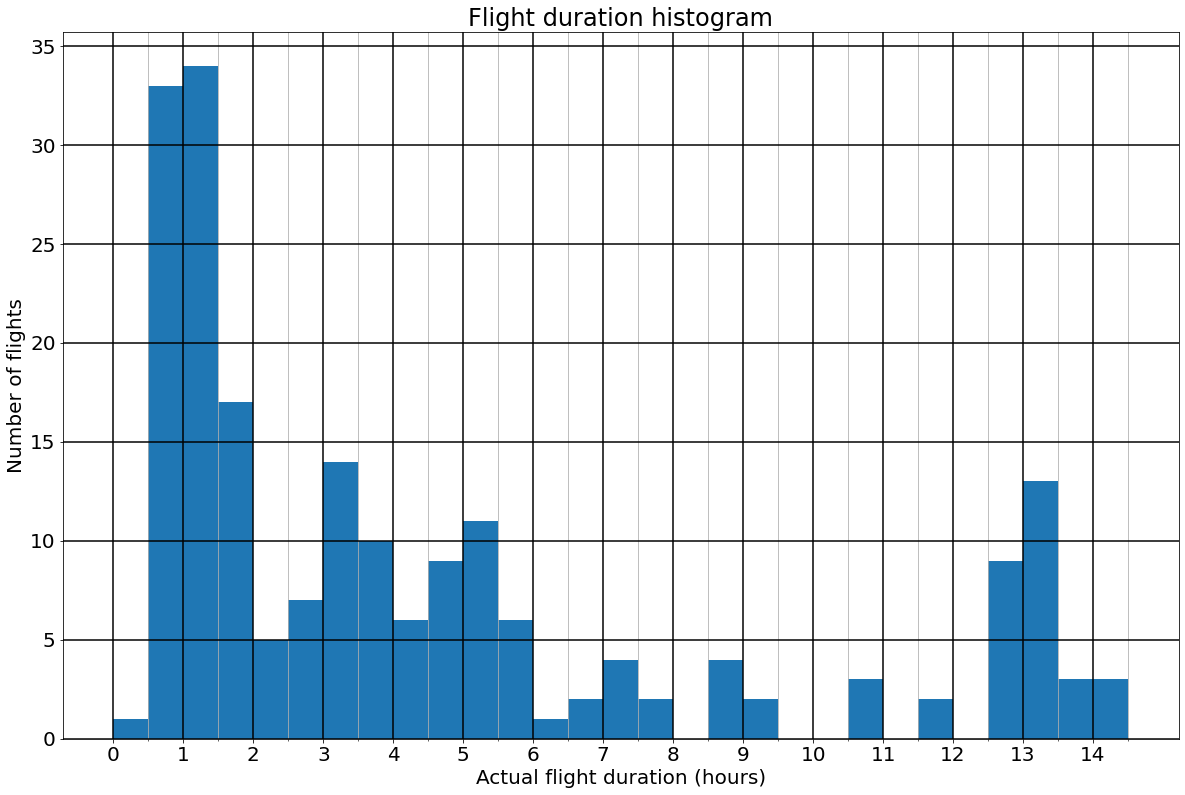

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(20,13))
bins = list(range(0, math.ceil(df['Duration'].max()/30)*30+30, 30))
ax.hist(df['Duration'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if i%2 == 0])
ax.set_xticklabels([b//60 for i, b in enumerate(bins) if i%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Actual flight duration (hours)')
ax.set_ylabel('Number of flights')
ax.set_title('Flight duration histogram')
plt.savefig('figures/duration_hist.jpg', bbox_inches='tight')

df.sort_values(['Duration'], ascending=False).head(10)[important_cols]

# ALL COUNTRIES AND AIRPORTS

In [183]:
dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
dep_countries.columns = ['Country', 'Airport', 'Departures']
arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
arr_countries.columns = ['Country', 'Airport', 'Arrivals']
connect_countries = df[df['Arr Connect'] == 1].groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
connect_countries.columns = ['Country', 'Airport', 'Connections']
countries = pd.merge(pd.merge(dep_countries, arr_countries, how='outer'), connect_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first', 'Connections': 'first'})
countries['Total Visits'] = countries['Departures'] + countries['Arrivals'] - countries['Connections']
countries['Departures'] = countries['Departures'] - countries['Connections']
countries['Arrivals'] = countries['Arrivals'] - countries['Connections']
countries.astype('int32')

Departures  Arrivals  Connections  Total Visits
Country               Airport                                                 
Australia             BNE               1         1            0             2
                      SYD               1         1            0             2
Bahamas               NAS               1         1            0             2
Bermuda               BDA               1         1            0             2
Canada                YYZ               0         0            1             1
China                 CTU               1         1            0             2
                      DNH               1         1            0             2
                      HGH               1         1            0             2
                      HRB               1         1            0             2
                      KJI               1         1            0             2
                      KMG               0         0            1             1
                      KWL               1         1            0             2
                      LHW               0         0            1             1
                      LJG               1         1            0             2
                      PEK              23        25            0            48
                      PVG               2         2            0             4
                      SHA               1         0            0             1
                      SYX               1         1            0             2
                      SZX               1         0            0             1
                      URC               2         2            0             4
                      WUX               1         1            0             2
                      XIY               0         0            1             1
Costa Rica            SJO               1         1            0             2
Dominican Republic    PUJ               1         1            0             2
France                CDG               2         2            0             4
                      NCE               1         1            0             2
Germany               FRA               0         0            2             2
                      MUC               0         0            1             1
Iceland               KEF               1         1            0             2
Italy                 FCO               1         1            0             2
Japan                 HND               1         0            0             1
                      KIX               1         1            0             2
                      NRT               0         1            0             1
Malaysia              KUL               1         1            0             2
Mexico                PVR               1         1            0             2
Portugal              LIS               0         0            3             3
Puerto Rico           SJU               1         1            0             2
Saint Kitts and Nevis SKB               1         1            0             2
Singapore             SIN               1         1            1             3
South Africa          CPT               2         1            0             3
                      PLZ               0         1            0             1
South Korea           GMP               1         1            0             2
                      ICN               1         1            0             2
Spain                 BCN               1         1            0             2
                      MAD               0         1            0             1
                      VLL               1         0            0             1
Thailand              BKK               0         1            0             1
                      DMK               1         0            0             1
Turkey                IST               2         2            0             4
  

# AIRPORTS SORTED BY TOTAL VISITS

In [184]:
countries_sorted = countries.sort_values(by=['Total Visits'], ascending=False)
countries_sorted = countries_sorted.astype('int32')
countries_sorted.head(20)

Departures  Arrivals  Connections  Total Visits
Country              Airport                                                 
United States        BOS              37        36            0            73
China                PEK              23        25            0            48
United States        EWR               4         4           22            30
                     SFO              10        11            3            24
                     ORD               2         2            4             8
                     DEN               1         1            5             7
                     IAD               0         0            7             7
                     PHL               3         4            0             7
                     LAX               3         3            1             7
                     JFK               1         1            2             4
China                PVG               2         2            0             4
United States        DTW               2         2            0             4
China                URC               2         2            0             4
Turkey               IST               2         2            0             4
France               CDG               2         2            0             4
United Arab Emirates DXB               1         1            1             3
South Africa         CPT               2         1            0             3
Singapore            SIN               1         1            1             3
Portugal             LIS               0         0            3             3
United States        IAH               0         0            3             3

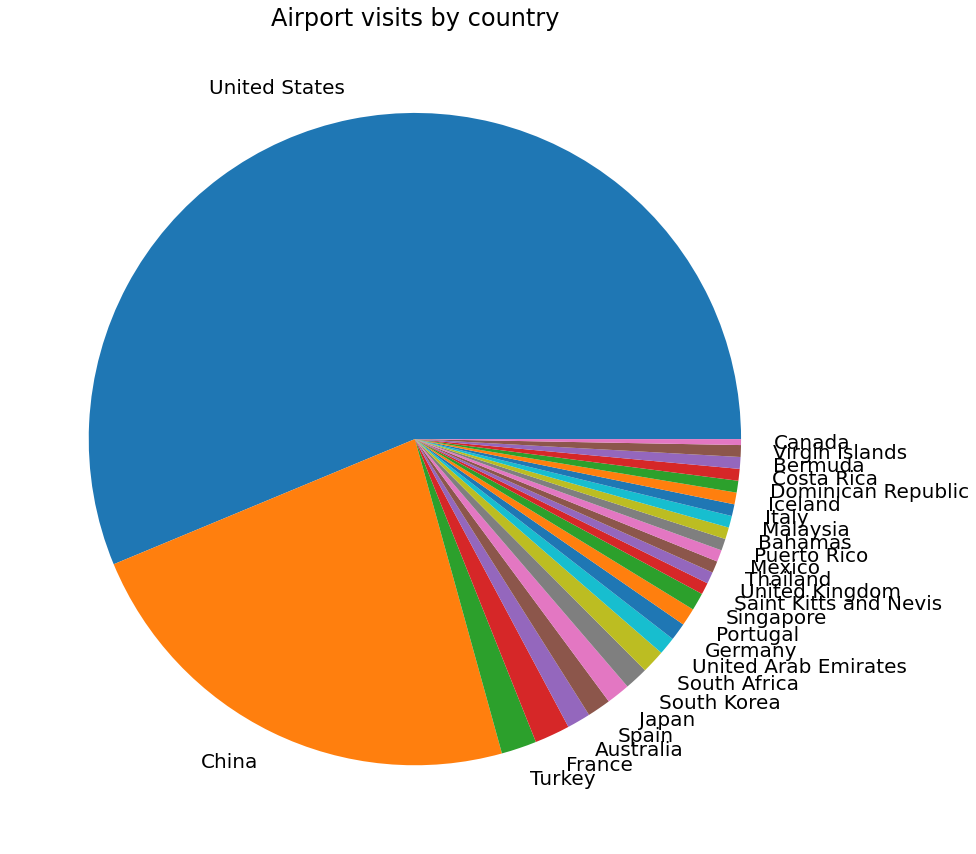

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
countries_sorted.reset_index().groupby('Country').agg({'Total Visits': sum}).sort_values(by='Total Visits', ascending=False).plot('Country', 'Total Visits', kind='pie', legend=False, ax=ax)
ax.set_title('Airport visits by country')
ax.set_ylabel('')
plt.savefig('figures/countries.jpg', bbox_inches='tight')

# TOP ROUTES

In [186]:
routes = df.groupby(['Dep Airport', 'Arr Airport']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes.columns = ['Count', 'Total Distance']
routes.head(10)

Count  Total Distance
Dep Airport Arr Airport                       
BOS         EWR             14     2807.570070
EWR         BOS             12     2406.488631
            PEK             10    68309.228239
SFO         BOS              6    16224.706890
PEK         EWR              5    34154.614120
BOS         ORD              3     2599.949013
PEK         IAD              3    20762.252704
BOS         IAD              3     1238.508572
IAD         BOS              3     1238.508572
LAX         BOS              2     5222.264116

In [187]:
df['Sorted Route'] = df.apply(lambda row: str(sorted([row['Dep Airport'], row['Arr Airport']])[0]) + ' ' + str(sorted([row['Dep Airport'], row['Arr Airport']])[1]), axis=1)
routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes_sorted.columns = ['Count', 'Total Distance']
routes_sorted.head(8)

,Count,Total Distance
Sorted Route,,
BOS EWR,26,5214.058701
EWR PEK,15,102463.842359
BOS SFO,8,21632.942519
BOS IAD,6,2477.017144
BOS ORD,4,3466.598684
BOS DEN,4,7016.192200
BOS PHL,3,840.060616
BOS PEK,3,20209.866549


# TOP AIRLINES

In [188]:
airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum, 'Duration': sum}).sort_values(by='Date', ascending=False)
airlines.columns = ['Count', 'Total Distance', 'Duration']
airlines

,Count,Total Distance,Duration
Airline,,,
United,115,285870.233467,34281.0
Hainan,9,37994.846495,4518.0
JetBlue,9,14963.728435,1844.0
China Southern,7,5826.802274,893.0
TAP,6,17163.365833,2058.0
Lufthansa,5,10712.757129,1301.0
Air China,5,6760.300960,1040.0
American,5,4662.374153,654.0
China Eastern,5,4002.392049,583.0


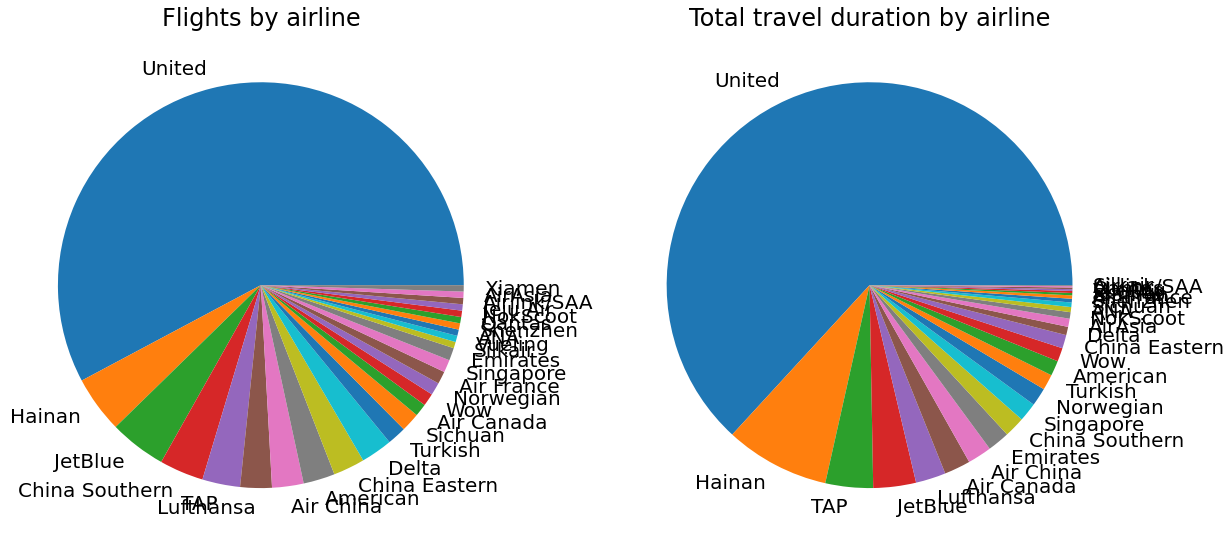

In [189]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
airlines.plot('Airline', 'Count', kind='pie', legend=False, ax=ax[0])
airlines.sort_values(by='Duration', ascending=False).plot('Airline', 'Duration', kind='pie', legend=False, ax=ax[1])
ax[0].set_title('Flights by airline')
ax[1].set_title('Total travel duration by airline')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig('figures/airlines.jpg', bbox_inches='tight')


# TOP AIRCRAFT

In [190]:
aircraft = df.groupby(['Aircraft']).agg({'Date': 'count', 'Distance': sum, 'Duration': sum}).sort_values(by='Date', ascending=False)
aircraft.columns = ['Count', 'Total Distance', 'Duration']
aircraft

,Count,Total Distance,Duration
Aircraft,,,
B738,29,36128.311019,4876.0
A320,25,19979.216986,2804.0
B772,23,137297.180470,15708.0
B739,15,8524.368972,1326.0
A321,12,17752.133920,2293.0
A319,11,8069.656310,1150.0
B789,11,47305.905249,5233.0
B752,8,20533.794475,2407.0
B737,8,4570.832260,736.0


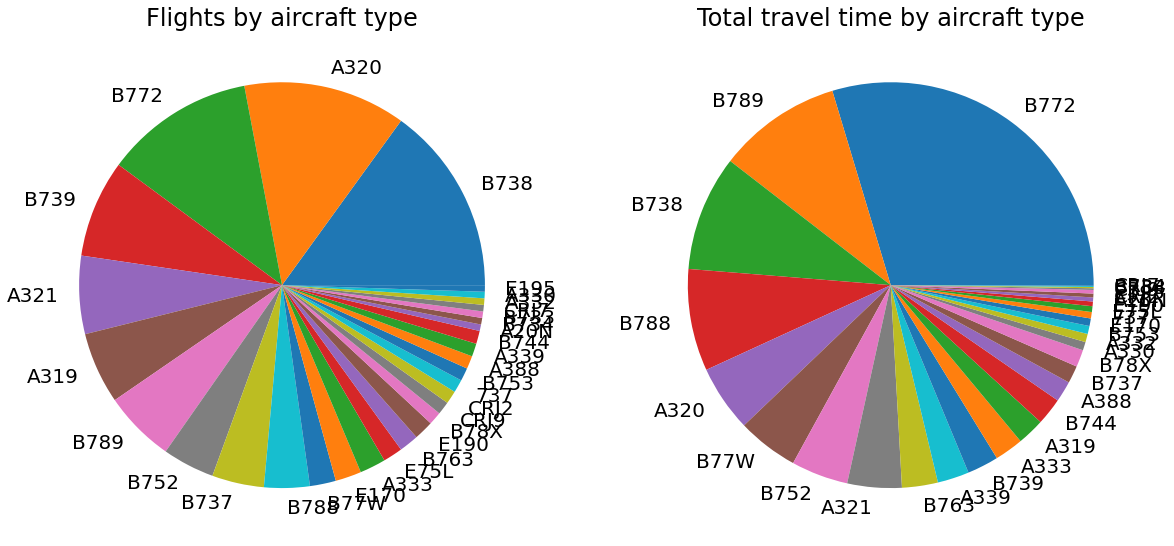

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
aircraft.plot('Aircraft', 'Count', kind='pie', legend=False, ax=ax[0])
aircraft.sort_values(by='Duration', ascending=False).plot('Aircraft', 'Duration', kind='pie', legend=False, ax=ax[1])
ax[0].set_title('Flights by aircraft type')
ax[1].set_title('Total travel time by aircraft type')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig('figures/aircrafts.jpg', bbox_inches='tight')


# TOP AIRCRAFT REGS

In [192]:
reg = df.groupby(['Registration', 'Aircraft']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False).head(15)
reg.columns = ['Count', 'Total Distance']
reg

,,Count,Total Distance
Registration,Aircraft,,
N78005,B772,3,20492.768472
N19136,B752,2,5408.235630
B2750,B788,2,14044.305986
N76010,B772,2,13661.845648
B7880,B789,2,1364.555397
N69020,B772,2,9249.750914
N33284,B738,2,1954.588769
N975JT,A321,2,3228.308085
N68842,B739,2,2314.623049


# TRAVEL BY YEAR

In [193]:
dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Duration': sum, 'Date': 'count'})
dist_year.columns = ['Distance', 'Duration', 'Flights']
missing_years = set(range(dist_year.index.min(), dist_year.index.max())) - set(dist_year.index)
for yr in missing_years:
    dist_year = dist_year.append(pd.DataFrame({'Distance': 0, 'Duration': 0, 'Flights': 0}, index=[yr]))
dist_year

,Distance,Duration,Flights
Date,,,
2015,29436.434579,3573.0,10
2016,58570.729684,7014.0,22
2017,78048.415226,9502.0,39
2018,77923.939884,9277.0,26
2019,84244.238494,10091.0,32
2020,48040.013756,6065.0,30
2021,58951.069745,7405.0,33
2022,11956.293123,1766.0,9


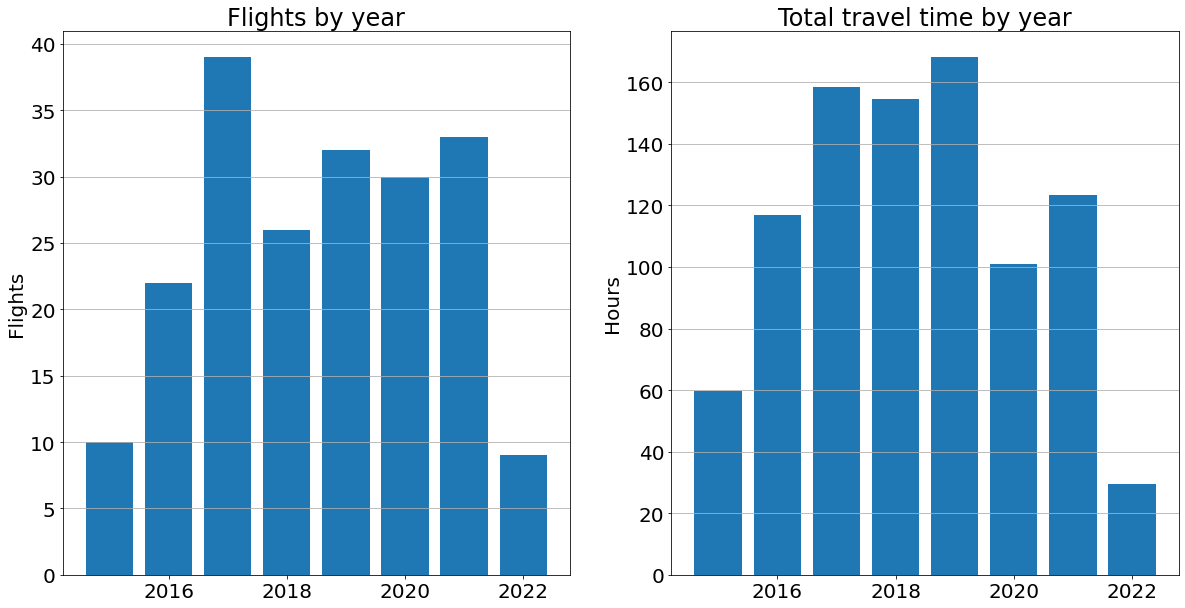

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].bar(dist_year.index, dist_year['Flights'])
ax[0].grid(axis='y')
ax[0].set_title('Flights by year')
ax[0].set_ylabel('Flights')
ax[1].bar(dist_year.index, dist_year['Duration']/60)
ax[1].grid(axis='y')
ax[1].set_title('Total travel time by year')
ax[1].set_ylabel('Hours')
plt.savefig('figures/by_year.jpg', bbox_inches='tight')


# TRAVEL BY MONTH

In [195]:
df['Month'] = df['Date']
dist_yearm = df.groupby([df['Date'].dt.year, df['Month'].dt.month]).agg({'Distance': sum, 'Duration': sum, 'Date': 'count'})
dist_yearm.columns = ['Distance', 'Duration', 'Flights']

dist_yearm.sort_values(by='Distance', ascending=False).head(30)

,,Distance,Duration,Flights
Date,Month,,,
2019,12,20870.665731,2402.0,7
2021,6,18558.120149,2313.0,10
2016,3,17481.756684,2162.0,8
2018,3,17028.219491,1969.0,3
2019,8,15448.226232,1750.0,3
2020,1,14596.349780,1782.0,8
2021,11,14545.201558,1794.0,6
2017,10,14365.050635,1696.0,4
2016,12,14231.539360,1762.0,6


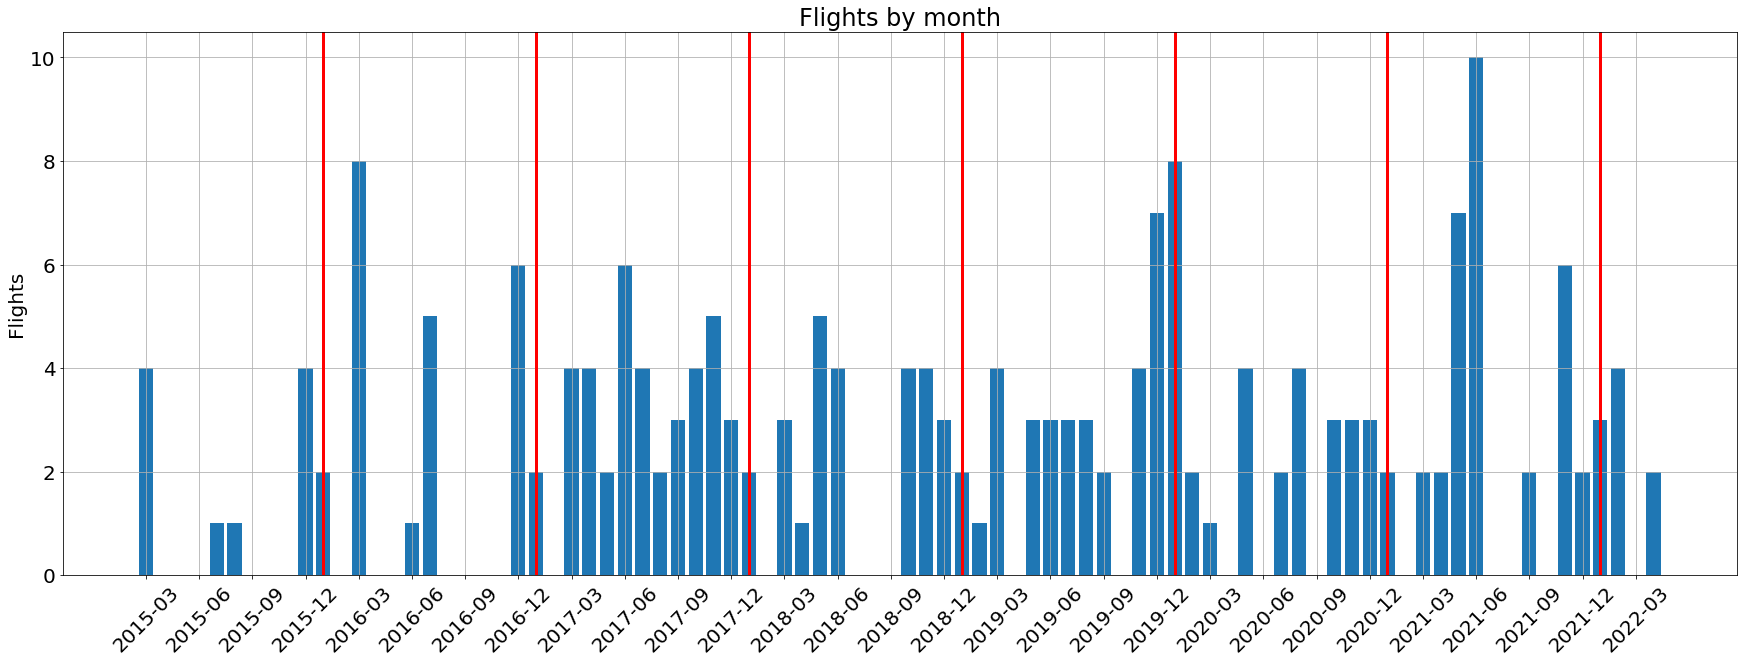

In [196]:
months = df['Month'].sort_values()
start_month = months.iloc[0]
end_month = months.iloc[-1]

index = pd.period_range(start_month, end_month, freq='M')
index_str = pd.DataFrame(index.astype(str), columns=['Y-M'])
# dist_yearm.reindex(index)

a = dist_yearm.reset_index()
a['Date'] = a['Date'].astype('int32').astype(str)
a['Month'] = a['Month'].astype('str').str.zfill(2)

a['Y-M'] = a['Date'] + '-' + a['Month']
a = a.merge(index_str, how='outer').sort_values(['Y-M']).fillna(0)

fig, ax = plt.subplots(figsize=(30,10))
ax.bar(a['Y-M'], a['Flights'], linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Flights')
ax.set_title('Flights by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig('figures/flights_by_month.jpg', bbox_inches='tight')


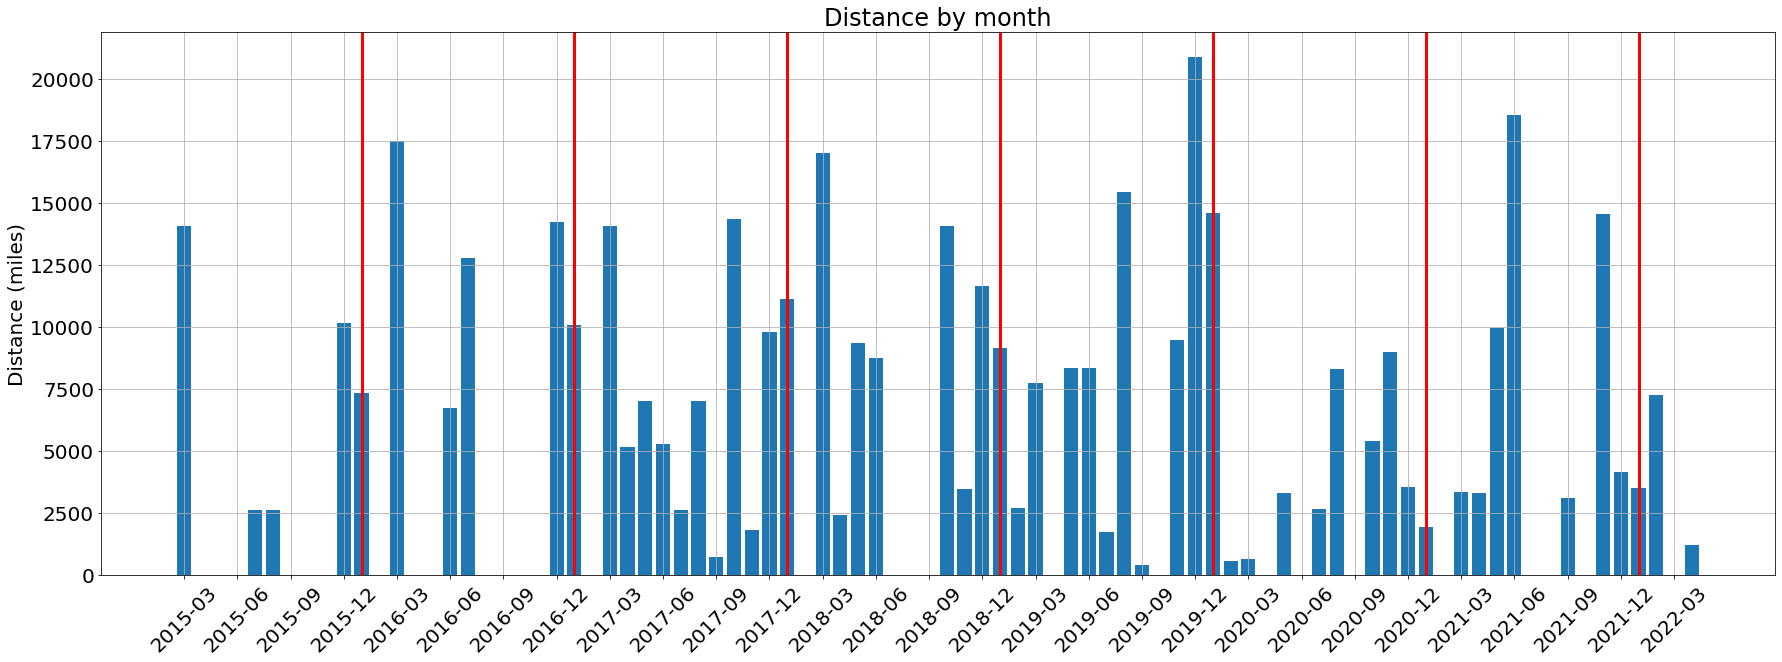

In [197]:
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(a['Y-M'], a['Distance'], linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Distance (miles)')
ax.set_title('Distance by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig('figures/distance_month.jpg', bbox_inches='tight')

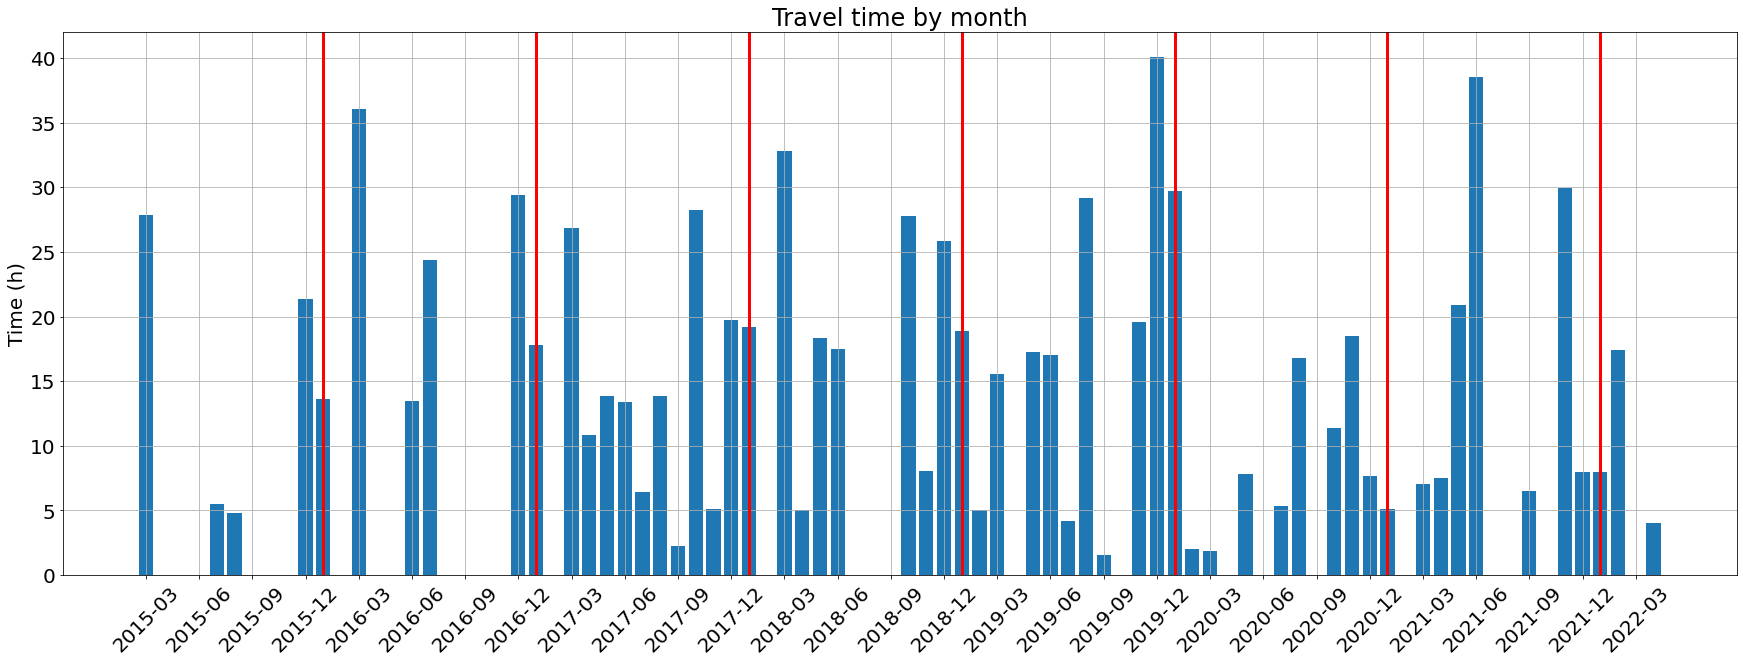

In [198]:
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(a['Y-M'], a['Duration']/60, linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Time (h)')
ax.set_title('Travel time by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig('figures/time_month.jpg', bbox_inches='tight')

# DOMESTIC AND INTERNATIONAL BREAKDOWN

In [199]:
dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count'})
dom_int.columns = ['Distance', 'Flights']
dom_int

,Distance,Flights
Domestic/International,,
Domestic,133879.086573,128
International,313292.047918,73


In [200]:
print('Domestic average dist: ' + str(dom_int.loc['Domestic', 'Distance'] / dom_int.loc['Domestic', 'Flights']))
print('International average dist: ' + str(dom_int.loc['International', 'Distance'] / dom_int.loc['International', 'Flights']))

Domestic average dist: 1045.930363852303
International average dist: 4291.671889291932


In [201]:
year_dom_int = df.groupby([df['Date'].dt.year, 'Domestic/International']).agg({'Distance': sum, 'Date': 'count'})
year_dom_int.columns = ['Distance', 'Flights']
year_dom_int

Distance  Flights
Date Domestic/International                       
2015 Domestic                 8943.666107        7
     International           20492.768472        3
2016 Domestic                11296.768030       13
     International           47273.961655        9
2017 Domestic                18719.510846       28
     International           59328.904380       11
2018 Domestic                 7371.939874       11
     International           70552.000010       15
2019 Domestic                16722.896473       17
     International           67521.342021       15
2020 Domestic                35641.590777       24
     International           12398.422979        6
2021 Domestic                28859.795613       22
     International           30091.274133       11
2022 Domestic                 6322.918853        6
     International            5633.374271        3

In [202]:
clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count'})
clas.columns = ['Distance', 'Flights']
clas

,Distance,Flights
Class,,
Business,159330.557878,54
Economy,278823.552497,141
Premium,2418.828090,1


# FARE CLASS BREAKDOWN

In [203]:
year_clas = df.groupby([df['Date'].dt.year, 'Class']).agg({'Distance': sum, 'Date': 'count'})
year_clas.columns = ['Distance', 'Flights']
year_clas

Distance  Flights
Date Class                          
2015 Business    401.081439        2
     Economy   29035.353141        8
2016 Business  27053.538848        6
     Economy   31517.190836       16
2017 Business  26942.325389        7
     Economy   51106.089836       32
2018 Business  18262.603286        7
     Economy   59661.336598       19
2019 Business  38705.464773        9
     Economy   45538.773721       23
2020 Business  20535.636355       11
     Economy   27504.377401       19
2021 Business  22071.810690        8
     Economy   34460.430966       24
     Premium    2418.828090        1
2022 Business   5358.097097        4


# CLASS AND TRIP TYPE BREAKDOWN

In [204]:
clas_dom_int = df.groupby(['Domestic/International', 'Class']).agg({'Distance': sum, 'Date': 'count'})
clas_dom_int.columns = ['Distance', 'Flights']
clas_dom_int

Distance  Flights
Domestic/International Class                           
Domestic               Business   37549.918096       29
                       Economy    91077.445336       95
                       Premium     2418.828090        1
International          Business  121780.639782       25
                       Economy   187746.107162       46

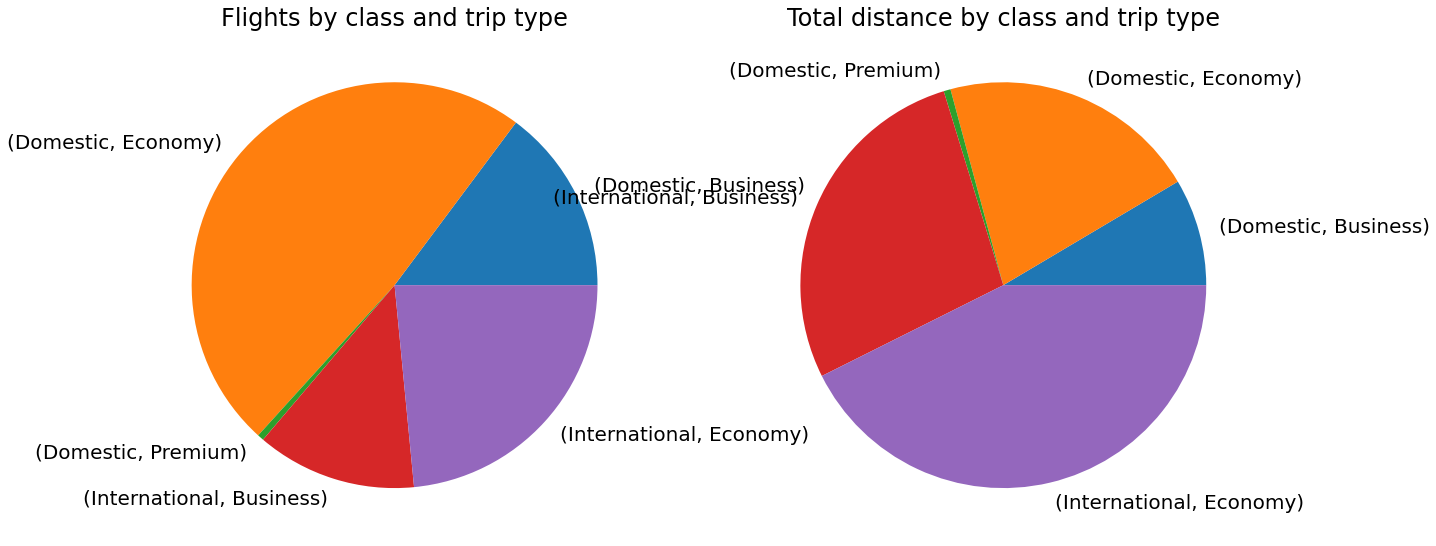

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
clas_dom_int.plot('Class', 'Flights', kind='pie', legend=False, ax=ax[0])
clas_dom_int.plot('Class', 'Distance', kind='pie', legend=False, ax=ax[1])
ax[0].set_title('Flights by class and trip type')
ax[1].set_title('Total distance by class and trip type')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig('figures/class_and_type.jpg', bbox_inches='tight')

# DEP, ARR TIMES, DELAYS

In [206]:
# ARRIVAL DEAYS

early_arrivals = df[df['Arr Delay'] < 0].shape[0]
on_time_arrivals = df[(df['Arr Delay'] >= 0) & (df['Arr Delay'] < 15)].shape[0]
late_arrivals = df[(df['Arr Delay'] >= 15) & (df['Arr Delay'] < 60)].shape[0]
really_late_arrivals = df[df['Arr Delay'] >= 60].shape[0]

print('Early arrivals:', early_arrivals, str(round(100*early_arrivals/NUM_FLIGHTS))+'%')
print('On time arrivals (within 15 min):', on_time_arrivals, str(round(100*on_time_arrivals/NUM_FLIGHTS))+'%')
print('Late arrivals:', late_arrivals, str(round(100*late_arrivals/NUM_FLIGHTS))+'%')
print('Really late arrivals (1+hour):', really_late_arrivals, str(round(100*really_late_arrivals/NUM_FLIGHTS))+'%')

df.sort_values('Arr Delay', ascending=False).head(50)[important_cols]

Early arrivals: 140 70%
On time arrivals (within 15 min): 28 14%
Late arrivals: 19 9%
Really late arrivals (1+hour): 6 3%


,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Distance,Dep Delay,Arr Delay,Class,Aircraft,Registration
148,2020-08-28,2020-08-28 23:45:00,2020-08-29 06:51:00,04:28:00,United,UA1104,ANC,DEN,2405.320211,270.0,232.0,Economy,B738,N73275
35,2017-03-11,2017-03-11 12:00:00,2017-03-12 15:00:00,12:44:00,United,UA89,EWR,PEK,6830.922824,224.0,148.0,Economy,B772,N76010
175,2021-06-04,2021-06-04 15:10:00,2021-06-04 16:21:00,00:47:00,United,UA3433,EWR,BOS,200.540719,170.0,146.0,Economy,E170,N646RW
137,2020-02-19,2020-02-19 06:46:00,2020-02-19 08:25:00,01:16:00,JetBlue,B6159,BOS,PHL,280.020205,109.0,86.0,Economy,A321,N903JB
125,2019-12-18,2019-12-18 20:30:00,2019-12-19 18:00:00,13:34:00,United,UA1122,EWR,CPT,7816.760114,134.0,77.0,Business,B789,N27957
76,2018-04-02,2018-04-02 15:30:00,2018-04-02 17:35:00,05:04:00,Wow,WW125,KEF,BOS,2412.851885,121.0,60.0,Economy,A321,TFMOM
45,2017-06-09,2017-06-09 08:40:00,2017-06-09 09:45:00,01:06:00,China Southern,CZ6613,URC,KJI,298.921899,58.0,59.0,Economy,B737,B5239
51,2017-07-19,2017-07-19 22:10:00,2017-07-20 00:30:00,01:37:00,Hainan,HU7610,PVG,PEK,682.277699,100.0,57.0,Economy,B789,B7880
97,2019-01-06,2019-01-06 23:55:00,2019-01-07 05:05:00,13:50:00,Air Canada,AC57,DXB,YYZ,6899.002047,74.0,54.0,Business,B77W,CFRAM
79,2018-05-28,2018-05-28 12:05:00,2018-05-28 13:25:00,01:15:00,Vueling,VY1585,VLL,BCN,360.562576,58.0,53.0,Economy,A320,ECKDT


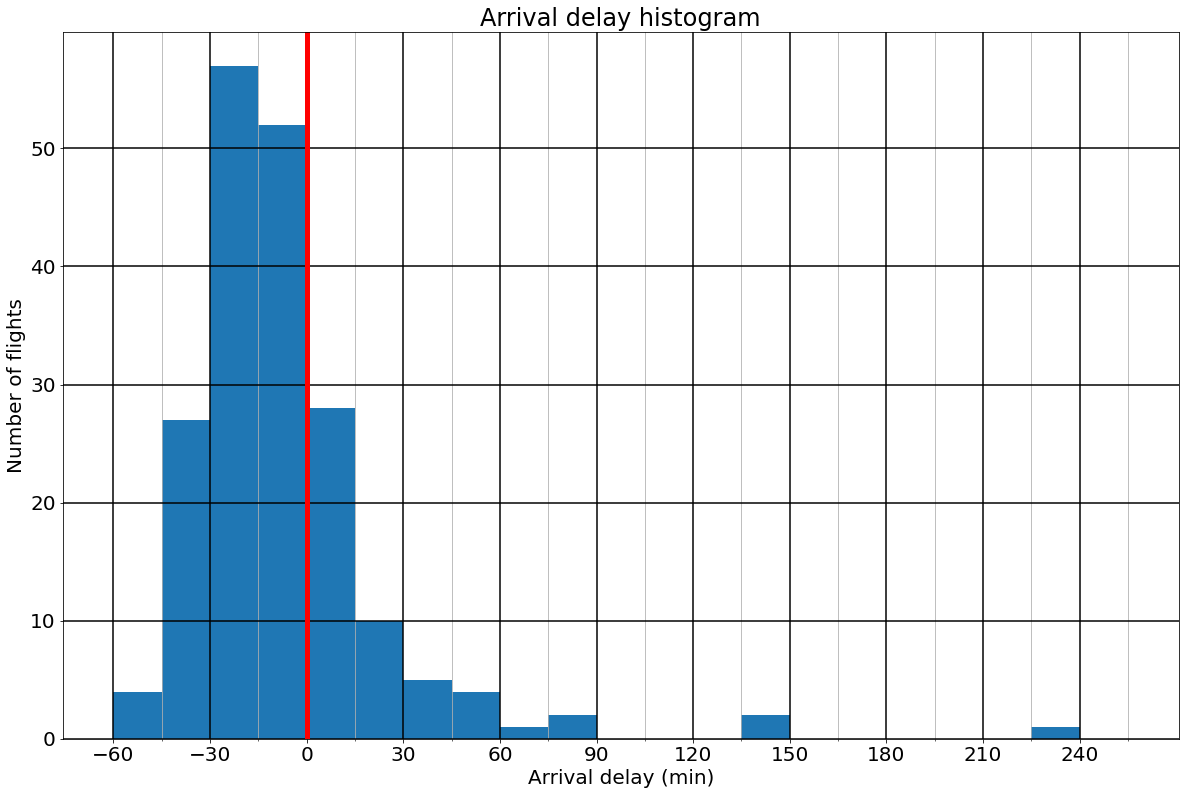

In [207]:
bins = list(range(-60, math.ceil(df['Arr Delay'].max()/30)*30+30, 15))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(df['Arr Delay'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Arrival delay (min)')
ax.set_ylabel('Number of flights')
ax.set_title('Arrival delay histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig('figures/arrival_delay.jpg', bbox_inches='tight')


In [208]:
# DEPARTURE DELAYS

early_departures = df[df['Dep Delay'] < 0].shape[0]
on_time_departures = df[(df['Dep Delay'] >= 0) & (df['Dep Delay'] < 15)].shape[0]
late_departures = df[(df['Dep Delay'] >= 15) & (df['Dep Delay'] < 60)].shape[0]
really_late_departures = df[df['Dep Delay'] >= 60].shape[0]


print('Early departures:', early_departures, str(round(100*early_departures/NUM_FLIGHTS))+'%')
print('On time departures (within 15 min):', on_time_departures, str(round(100*on_time_departures/NUM_FLIGHTS))+'%')
print('Late departures:', late_departures, str(round(100*late_departures/NUM_FLIGHTS))+'%')
print('Really late departures (1+hour):', really_late_departures, str(round(100*really_late_departures/NUM_FLIGHTS))+'%')

df.sort_values('Dep Delay', ascending=False).head(10)[important_cols]

Early departures: 2 1%
On time departures (within 15 min): 72 36%
Late departures: 108 54%
Really late departures (1+hour): 11 5%


,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Distance,Dep Delay,Arr Delay,Class,Aircraft,Registration
148,2020-08-28,2020-08-28 23:45:00,2020-08-29 06:51:00,04:28:00,United,UA1104,ANC,DEN,2405.320211,270.0,232.0,Economy,B738,N73275
35,2017-03-11,2017-03-11 12:00:00,2017-03-12 15:00:00,12:44:00,United,UA89,EWR,PEK,6830.922824,224.0,148.0,Economy,B772,N76010
175,2021-06-04,2021-06-04 15:10:00,2021-06-04 16:21:00,00:47:00,United,UA3433,EWR,BOS,200.540719,170.0,146.0,Economy,E170,N646RW
125,2019-12-18,2019-12-18 20:30:00,2019-12-19 18:00:00,13:34:00,United,UA1122,EWR,CPT,7816.760114,134.0,77.0,Business,B789,N27957
76,2018-04-02,2018-04-02 15:30:00,2018-04-02 17:35:00,05:04:00,Wow,WW125,KEF,BOS,2412.851885,121.0,60.0,Economy,A321,TFMOM
137,2020-02-19,2020-02-19 06:46:00,2020-02-19 08:25:00,01:16:00,JetBlue,B6159,BOS,PHL,280.020205,109.0,86.0,Economy,A321,N903JB
51,2017-07-19,2017-07-19 22:10:00,2017-07-20 00:30:00,01:37:00,Hainan,HU7610,PVG,PEK,682.277699,100.0,57.0,Economy,B789,B7880
97,2019-01-06,2019-01-06 23:55:00,2019-01-07 05:05:00,13:50:00,Air Canada,AC57,DXB,YYZ,6899.002047,74.0,54.0,Business,B77W,CFRAM
48,2017-06-24,2017-06-24 08:10:00,2017-06-24 11:30:00,01:37:00,China Southern,CZ317,PEK,GMP,577.175145,73.0,30.0,Economy,A320,B1653
158,2020-12-19,2020-12-19 08:42:00,2020-12-19 14:02:00,03:36:00,United,UA1562,EWR,SKB,1749.467856,63.0,19.0,Economy,B738,N26232


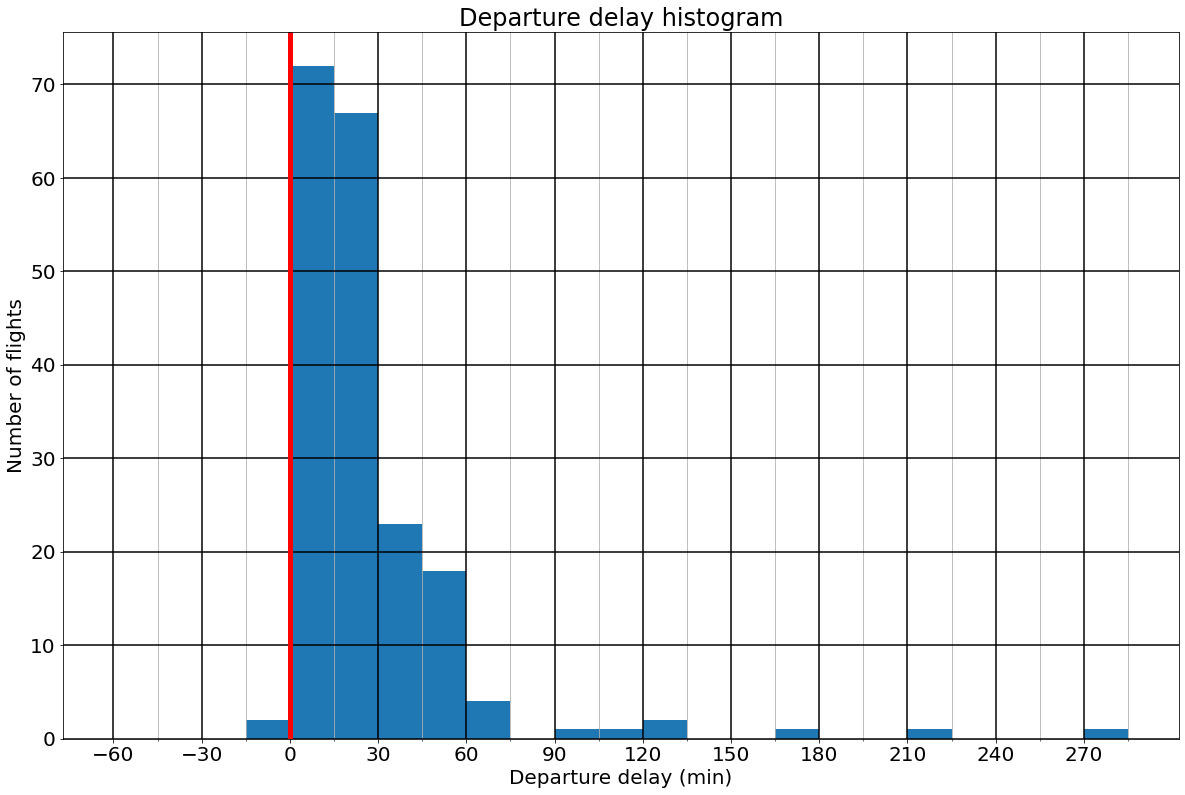

In [209]:
bins = list(range(-60, math.ceil(df['Dep Delay'].max()/30)*30+30, 15))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(df['Dep Delay'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Departure delay (min)')
ax.set_ylabel('Number of flights')
ax.set_title('Departure delay histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig('figures/departure_delay.jpg', bbox_inches='tight')


# DEPARTURE/ARRIVAL TIMES

Morning flights (5a-12p): 82, 41%
Afternoon flights (12p-6p): 66, 33%
Evening flights (6p-11p): 41, 20%
Late nights flights (11p-5a): 10, 5%


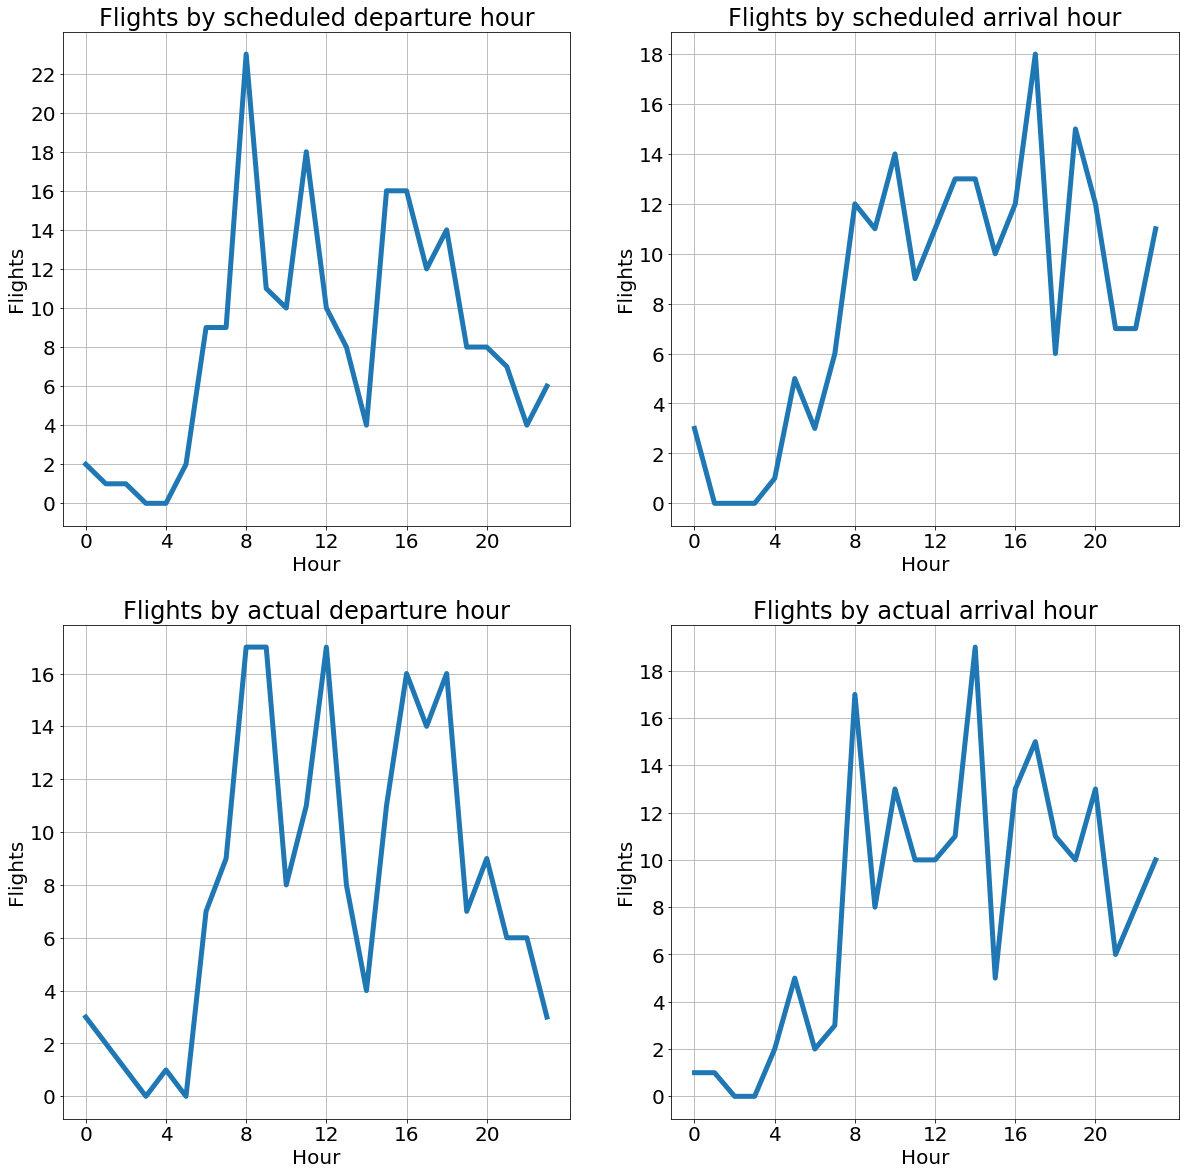

In [210]:
morning_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 5) & (df['Scheduled Dep Time (Local)'].dt.hour <= 11)].shape[0]
afternoon_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 12) & (df['Scheduled Dep Time (Local)'].dt.hour <= 17)].shape[0]
evening_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 18) & (df['Scheduled Dep Time (Local)'].dt.hour <= 22)].shape[0]
late_night_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 23) | (df['Scheduled Dep Time (Local)'].dt.hour <= 4)].shape[0]

print('Morning flights (5a-12p): ' + str(morning_flights) + ', ' + str(int(round(100*morning_flights/NUM_FLIGHTS))) + '%')
print('Afternoon flights (12p-6p): ' + str(afternoon_flights) + ', ' + str(int(round(100*afternoon_flights/NUM_FLIGHTS))) + '%')
print('Evening flights (6p-11p): ' + str(evening_flights) + ', ' + str(int(round(100*evening_flights/NUM_FLIGHTS))) + '%')
print('Late nights flights (11p-5a): ' + str(late_night_flights) + ', ' + str(int(round(100*late_night_flights/NUM_FLIGHTS))) + '%')

df['Scheduled dep hour'] = df['Scheduled Dep Time (Local)'].dt.hour
df['Scheduled arr hour'] = df['Scheduled Arr Time (Local)'].dt.hour
df['Actual dep hour'] = df['Actual Dep Time (Local)'].dt.hour
df['Actual arr hour'] = df['Actual Arr Time (Local)'].dt.hour

scheduled_dep_hour = df.groupby('Scheduled dep hour') .agg({'Date': 'count'}).reset_index().rename(columns={'Scheduled dep hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(scheduled_dep_hour['Hour']):
    scheduled_dep_hour = scheduled_dep_hour.append(pd.DataFrame({'Hour': h, 'Count': 0}, index=[0]))
scheduled_dep_hour = scheduled_dep_hour.sort_values(by='Hour')

scheduled_arr_hour = df.groupby('Scheduled arr hour').agg({'Date': 'count'}).reset_index().rename(columns={'Scheduled arr hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(scheduled_arr_hour['Hour']):
    scheduled_arr_hour = scheduled_arr_hour.append(pd.DataFrame({'Hour': h, 'Count': 0}, index=[0]))
scheduled_arr_hour = scheduled_arr_hour.sort_values(by='Hour')

actual_dep_hour = df.groupby('Actual dep hour').agg({'Date': 'count'}).reset_index().rename(columns={'Actual dep hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(actual_dep_hour['Hour']):
    actual_dep_hour = actual_dep_hour.append(pd.DataFrame({'Hour': h, 'Count': 0}, index=[0]))
actual_dep_hour = actual_dep_hour.sort_values(by='Hour')

actual_arr_hour = df.groupby('Actual arr hour').agg({'Date': 'count'}).reset_index().rename(columns={'Actual arr hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(actual_arr_hour['Hour']):
    actual_arr_hour = actual_arr_hour.append(pd.DataFrame({'Hour': h, 'Count': 0}, index=[0]))
actual_arr_hour = actual_arr_hour.sort_values(by='Hour')

fig, ax = plt.subplots(2, 2, figsize=(20,20))
ax[0, 0].plot(scheduled_dep_hour['Hour'], scheduled_dep_hour['Count'], linewidth=5)
ax[0, 0].grid(True)
ax[0, 0].set_xticks(range(0,24,4))
ax[0, 0].set_xlabel('Hour')
ax[0, 0].set_yticks(np.arange(min(scheduled_dep_hour['Count']), max(scheduled_dep_hour['Count'])+1, 2.0))
ax[0, 0].set_ylabel('Flights')
ax[0, 0].set_title('Flights by scheduled departure hour')

ax[1, 0].plot(actual_dep_hour['Hour'], actual_dep_hour['Count'], linewidth=5)
ax[1, 0].grid(True)
ax[1, 0].set_xticks(range(0,24,4))
ax[1, 0].set_xlabel('Hour')
ax[1, 0].set_yticks(np.arange(min(actual_dep_hour['Count']), max(actual_dep_hour['Count'])+1, 2.0))
ax[1, 0].set_ylabel('Flights')
ax[1, 0].set_title('Flights by actual departure hour')

ax[0, 1].plot(scheduled_arr_hour['Hour'], scheduled_arr_hour['Count'], linewidth=5)
ax[0, 1].grid(True)
ax[0, 1].set_xticks(range(0,24,4))
ax[0, 1].set_xlabel('Hour')
ax[0, 1].set_yticks(np.arange(min(scheduled_arr_hour['Count']), max(scheduled_arr_hour['Count'])+1, 2.0))
ax[0, 1].set_ylabel('Flights')
ax[0, 1].set_title('Flights by scheduled arrival hour')

ax[1, 1].plot(actual_arr_hour['Hour'], actual_arr_hour['Count'], linewidth=5)
ax[1, 1].grid(True)
ax[1, 1].set_xticks(range(0,24,4))
ax[1, 1].set_xlabel('Hour')
ax[1, 1].set_yticks(np.arange(min(actual_arr_hour['Count']), max(actual_arr_hour['Count'])+1, 2.0))
ax[1, 1].set_ylabel('Flights')
ax[1, 1].set_title('Flights by actual arrival hour')
plt.savefig('figures/by_hour.jpg', bbox_inches='tight')



# ROUTES

In [211]:
import pyproj
from geojson import LineString, Feature, FeatureCollection, dump
import geopy.distance


def get_hist(x):
    dct = {a: x.tolist().count(a) for a in x.tolist()}
    return ';'.join([str(list(dct.keys())[i]) + ',' + str(list(dct.values())[i]) for i in range(len(dct))])


def augment_routes(df):
    route_grouped = df.groupby('Sorted Route')
    df[['Class', 'Airline', 'Flight']] = df[['Class', 'Airline', 'Flight']].fillna('Unknown')
    df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
    df['route_class_hist'] = route_grouped['Class'].transform(get_hist)#(lambda x: str(x.tolist().count('Economy')) + ',' + str(x.tolist().count('Business')))
    df['route_airline_hist'] = route_grouped['Airline'].transform(get_hist)
    df['route_flight_string'] = route_grouped['Flight'].transform(lambda x: ';'.join(x))
    df['route_origin_hist'] = route_grouped['Dep Airport'].transform(get_hist)
    grouped = df.groupby('Sorted Route').first()[['Distance', 'Duration', 'Domestic/International',
                                        'route_date_string', 'route_class_hist', 'route_airline_hist', 'route_flight_string', 'route_origin_hist'
                                       ]]
    grouped['count'] = grouped['route_date_string'].apply(lambda x: len(x.split(';')))

    grouped = grouped.reset_index()
    grouped['Dep IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[0])
    grouped['Arr IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[1])
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Dep IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'City': 'Dep City', 'Country': 'Dep Country', 'Lat': 'Dep Lat', 'Long': 'Dep Long'})
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Arr IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'City': 'Arr City', 'Country': 'Arr Country', 'Lat': 'Arr Lat', 'Long': 'Arr Long'})

    return grouped




def get_path(startlong, startlat, endlong, endlat):
    # calculate distance between points
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

    # calculate line string along path with segments <= 1 km
    lonlats = g.npts(startlong, startlat, endlong, endlat,
                     1 + int(dist / 5000))
    
    # npts doesn't include start/end points, so prepend/append them
    lonlats.insert(0, (startlong, startlat))
    lonlats.append((endlong, endlat))
    offset = 0
    for i in range(len(lonlats)-1):
        if lonlats[i][0] > 0 and lonlats[i+1][0] < 0 and lonlats[i+1][0] < -170:
            offset = 360
        elif lonlats[i][0] < 0 and lonlats[i+1][0] > 0 and lonlats[i+1][0] > 170:
            offset = -360
        lonlats[i+1] = (lonlats[i+1][0] + offset , lonlats[i+1][1])
#     print(len(lonlats))
    return LineString(lonlats)


def make_route_geojson(df, path):
    
    grouped = augment_routes(df)
    
    features = []
    for i, row in grouped.iterrows():
    #     lats = row['Sorted Lat'].split(';')
    #     longs = row['Sorted Long'].split(';')
        properties = properties = {'start_iata': row['Dep IATA'], 
                              'start_name': row['Dep Name'], 
                              'start_city_country': row['Dep City'] + ', ' + row['Dep Country'], 
                              'end_iata': row['Arr IATA'], 
                              'end_name': row['Arr Name'], 
                              'end_city_country': row['Arr City'] + ', ' + row['Arr Country'],  
                              'dist': row['Distance'], 
                              'dur': row['Duration'],
                              'domint': row['Domestic/International'],
                              'count': row['count'],
                              'earliest_date': row['route_date_string'].split(';')[0].split(' ')[0],
                              'latest_date': row['route_date_string'].split(';')[-1].split(' ')[0],
                              'date_string': row['route_date_string'],
                              'class_hist': row['route_class_hist'],
                              'airline_hist': row['route_airline_hist'],
                              'flight_string': row['route_flight_string'],
                              'origin_hist': row['route_origin_hist']
                             }
        features.append(Feature(geometry=get_path(row['Dep Long'], row['Dep Lat'], 
                                                  row['Arr Long'], row['Arr Lat']),
                                properties = properties))
    fc = FeatureCollection(features)

    with open(path, 'w') as f:
        dump(fc, f)



# AIRPORTS AUGMENTED

In [212]:
from geojson import Point, Feature, FeatureCollection, dump

def augment_airports(df):
    df['Year'] = df['Date'].dt.year

    dep_grouped = df.groupby('Dep Airport')
    df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
    df['dep_count'] = dep_grouped['Date'].transform(lambda v: v.shape[0])
    df['dep_first'] = dep_grouped['Date'].transform(lambda v: min(v))
    df['dep_last'] = dep_grouped['Date'].transform(lambda v: max(v))
    df['dep_airline_hist'] = dep_grouped['Airline'].transform(get_hist)
    df['dep_intdom_hist'] = dep_grouped['Domestic/International'].transform(get_hist)
    df['dep_year_hist'] = dep_grouped['Year'].transform(get_hist)

    arr_grouped = df.groupby('Arr Airport')
    df['arr_dest_hist'] = arr_grouped['Dep Airport'].transform(get_hist)
    df['arr_count'] = arr_grouped['Date'].transform(lambda v: v.shape[0])
    df['arr_first'] = arr_grouped['Date'].transform(lambda v: min(v))
    df['arr_last'] = arr_grouped['Date'].transform(lambda v: max(v))
    df['arr_conn_count'] = arr_grouped['Arr Connect'].transform(lambda v: int(v.sum())).astype('int')
    df['arr_airline_hist'] = arr_grouped['Airline'].transform(get_hist)
    df['arr_intdom_hist'] = arr_grouped['Domestic/International'].transform(get_hist)
    df['arr_year_hist'] = arr_grouped['Year'].transform(get_hist)

    df['arr_conn_year_hist'] = df[df['Arr Connect'] == 1].groupby('Arr Airport')['Year'].transform(get_hist)

    df = df.drop(columns='arr_conn_year_hist').merge(df[['Arr Airport', 'arr_conn_year_hist']].dropna().drop_duplicates(), on='Arr Airport', how='left')

    deps = df.groupby('Dep Airport').first()[['Dep Name', 'Dep City', 'Dep Country', 'Dep Lat', 'Dep Long',
                                       'dep_dest_hist', 'dep_count', 'dep_first', 'dep_last', 'dep_airline_hist', 'dep_intdom_hist', 'dep_year_hist'
                                      ]].reset_index()
    arrcons = df.groupby('Arr Airport').first()[['Arr Name', 'Arr City', 'Arr Country', 'Arr Lat', 'Arr Long',
                                                 'arr_dest_hist', 'arr_count', 'arr_first', 'arr_last', 'arr_airline_hist', 'arr_intdom_hist', 'arr_year_hist',
                                       'arr_conn_count', 'arr_conn_year_hist'
                                      ]].reset_index()
    airports_aug = deps.merge(arrcons, left_on='Dep Airport', right_on='Arr Airport', how='outer')
    
    def merge_names(row):
        for col in ['Airport', 'Name', 'City', 'Country']:
            row[col] = row['Dep '+ col] if type(row['Dep '+ col]) == str else row['Arr '+ col]
        for col in ['Lat', 'Long']:
            row[col] = row['Dep '+ col] if not np.isnan(row['Dep '+ col]) else row['Arr '+ col]
        return row


    airports_aug = airports_aug.apply(merge_names, axis=1)
    airports_aug = airports_aug.rename(columns={'Airport': 'IATA'})

    airports_aug = airports_aug[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long',
                                 'dep_count', 'arr_count', 'arr_conn_count',
                                 'dep_dest_hist', 'arr_dest_hist',
                                 'dep_first', 'arr_first', 'dep_last', 'arr_last',
                                 'dep_airline_hist', 'arr_airline_hist',
                                 'dep_intdom_hist', 'arr_intdom_hist',
                                 'dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist'
                                ]]
    airports_aug['dep_count'] = airports_aug['dep_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)
    airports_aug['arr_count'] = airports_aug['arr_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)

    def subtract_hist(row):
        dep_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['dep_year_hist'].split(';')} if row['dep_year_hist'] != '' else {}
        arr_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_year_hist'].split(';')} if row['arr_year_hist'] != '' else {}
        conn_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_conn_year_hist'].split(';')} if row['arr_conn_year_hist'] != '' else {}

        for year in conn_hist:
            if year in dep_hist:
                dep_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in dep')
            if year in arr_hist:
                arr_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in arr')

        row['dep_year_hist'] = ';'.join([str(x) + ',' + str(dep_hist[x]) for x in dep_hist if dep_hist[x] > 0])
        row['arr_year_hist'] = ';'.join([str(x) + ',' + str(arr_hist[x]) for x in arr_hist if arr_hist[x] > 0])
        full_year_hist = {}
        for key in dep_hist:
            full_year_hist[key] = full_year_hist[key] + dep_hist[key] if key in full_year_hist else dep_hist[key]
        for key in arr_hist:
            full_year_hist[key] = full_year_hist[key] + arr_hist[key] if key in full_year_hist else arr_hist[key]
        for key in conn_hist:
            full_year_hist[key] = full_year_hist[key] + conn_hist[key] if key in full_year_hist else conn_hist[key]
        row['full_year_hist'] = ';'.join([str(x) + ',' + str(full_year_hist[x]) for x in full_year_hist if full_year_hist[x] > 0])
        return row

    airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']] = airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']].fillna('')
    airports_aug = airports_aug.apply(subtract_hist, axis=1)
    airports_aug['total'] = airports_aug['dep_count'].fillna(0) + airports_aug['arr_count'].fillna(0) + airports_aug['arr_conn_count'].fillna(0)
    airports_aug['first'] = airports_aug.apply(lambda row: min(row['dep_first'], row['arr_first']), axis=1)
    airports_aug['last'] = airports_aug.apply(lambda row: min(row['dep_last'], row['arr_last']), axis=1)
    year_airports_aug.append(airports_aug)
    return airports_aug

def make_airport_geojson(df, path):
    airports_aug = augment_airports(df)
    for col in ['dep_first', 'arr_first', 'dep_last', 'arr_last', 'first', 'last']:
        airports_aug[col] = airports_aug[col].dt.strftime('%Y-%m-%d')
    airports_aug = airports_aug.fillna('')
    features = []
    for i, row in airports_aug.iterrows():
#         print(row.drop(['Lat', 'Long']).to_dict())
        features.append(Feature(geometry=Point((row['Long'], row['Lat'])), properties=row.drop(['Lat', 'Long']).to_dict()))
    fc = FeatureCollection(features)
    with open(path, 'w') as f:
        dump(fc, f)


In [213]:
#### MAKE ROUTES
year_airports_aug = [] # first one is all

make_route_geojson(df, ROOT_DIR + 'routes_all.geojson')
make_airport_geojson(df, ROOT_DIR + 'airports_all.geojson')

all_years = df['Date'].dt.year.unique().tolist()
first_month = min(df[df['Date'].dt.year == all_years[0]]['Date'].dt.month)
last_month = max(df[df['Date'].dt.year == all_years[-1]]['Date'].dt.month)

with open(ROOT_DIR + "month_range.txt", "w") as text_file:
    text_file.write(','.join(str(x) for x in all_years) + '\n' + str(first_month) + ',' + str(last_month))

for year in all_years:
    make_route_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'routes_' + str(year) + '.geojson')
    make_airport_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'airports_' + str(year) + '.geojson')

print('years done')

for year in all_years:
    print(year)
    for month in range(1, 13):
        if year == all_years[0] and month < first_month:
            continue
        if year == all_years[-1] and month > last_month:
            continue
        print('  ', month)
        simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
        make_route_geojson(simp_df, ROOT_DIR + 'routes_cum_' + str(year) + '_' + str(month) + '.geojson')
        make_airport_geojson(simp_df, ROOT_DIR + 'airports_cum_' + str(year) + '_' + str(month) + '.geojson')
    


/Users/alexanderguo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-211-373e90645454>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
<ipython-input-211-373e90645454>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

<ipython-input-212-3449acb59ab2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_intdom_hist'] = dep_grouped['Domestic/International'].transform(get_hist)
<ipython-input-212-3449acb59ab2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_year_hist'] = dep_grouped['Year'].transform(get_hist)
<ipython-input-212-3449acb59ab2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

<ipython-input-212-3449acb59ab2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_year_hist'] = dep_grouped['Year'].transform(get_hist)
<ipython-input-212-3449acb59ab2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arr_dest_hist'] = arr_grouped['Dep Airport'].transform(get_hist)
<ipython-input-212-3449acb59ab2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

<ipython-input-212-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-212-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-212-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

<ipython-input-212-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-212-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-212-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

<ipython-input-212-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-212-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-212-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

<ipython-input-212-3449acb59ab2>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arr_year_hist'] = arr_grouped['Year'].transform(get_hist)
<ipython-input-212-3449acb59ab2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arr_conn_year_hist'] = df[df['Arr Connect'] == 1].groupby('Arr Airport')['Year'].transform(get_hist)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'

years done
2015
   3
   4
   5


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6
   7
   8


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9
   10


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11
   12


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2016
   1
   2


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3
   4


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5
   6


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7
   8


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11
   12


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2017
   1


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2018
   1


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2019
   1


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2020
   1


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2020 not in dep
   12


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2021
   1


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2022
   1


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-213-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


# PRINTING

In [214]:
def get_stats(df, airports_aug, year=None, ab=False):
    print(year)
    TOTAL_DIST = df['Distance'].sum()
    TOTAL_TIME = df['Duration'].sum()
    NUM_FLIGHTS = df['Date'].count()
    NUM_AIRLINES = df['Airline'].nunique()
    NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
    NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))

    dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
    dep_countries.columns = ['Country', 'Airport', 'Departures']
    arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
    arr_countries.columns = ['Country', 'Airport', 'Arrivals']
    countries = pd.merge(dep_countries, arr_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first'})
    countries['Total Dep/Arr'] = countries['Departures'] + countries['Arrivals']

    routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum, 'Duration': sum}).sort_values(by='Date', ascending=False)
    routes_sorted.columns = ['Count', 'Total Distance', 'Duration']

    airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum, 'Duration': sum}).sort_values(by='Date', ascending=False)
    airlines.columns = ['Count', 'Total Distance', 'Duration']

    dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Date': 'count', 'Duration': sum})
    dist_year.columns = ['Distance', 'Flights', 'Duration']

    dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count', 'Duration': sum})
    dom_int.columns = ['Distance', 'Flights', 'Duration']

    clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count', 'Duration': sum})
    clas.columns = ['Distance', 'Flights', 'Duration']
   
    early_arrivals = df[df['Arr Delay'] < 0].shape[0]
    on_time_arrivals = df[(df['Arr Delay'] >= 0) & (df['Arr Delay'] < 15)].shape[0]
    late_arrivals = df[(df['Arr Delay'] >= 15) & (df['Arr Delay'] < 60)].shape[0]
    really_late_arrivals = df[df['Arr Delay'] >= 60].shape[0]

    morning_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 5) & (df['Scheduled Dep Time (Local)'].dt.hour <= 11)].shape[0]
    afternoon_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 12) & (df['Scheduled Dep Time (Local)'].dt.hour <= 17)].shape[0]
    evening_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 18) & (df['Scheduled Dep Time (Local)'].dt.hour <= 22)].shape[0]
    late_night_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 23) | (df['Scheduled Dep Time (Local)'].dt.hour <= 4)].shape[0]

    def get_time(minutes):
        return [int(minutes//60), int(minutes % 60)]

    def get_time_str(minutes):
        if get_time(minutes)[0] == 0:
            return str(get_time(minutes)[1]) + 'min'
        else:
            return str(get_time(minutes)[0]) + 'h ' + str(get_time(minutes)[1]) + 'm'

        
    big_str = ''
    if ab:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(first_month) + '/' + str(all_years[0]) + '-' + str(last_month) + '/' + str(all_years[-1]) + ')</span></h2>'
    else:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(year) + ')</span></h2>'
        
    big_str += '<p>Total Distance Flown: <span class=\'bold\'>' + '{:,}'.format(TOTAL_DIST).split('.')[0] + '</span>mi' + '\n'
    big_str += '<br>Total Time in Air: <span class=\'bold\'>' + str(timedelta(minutes=int(TOTAL_TIME))) + '</span>' + '\n'
    big_str += '<br>Total Flights: <span class=\'bold\'>' + str(NUM_FLIGHTS) + '</span>' + '\n'
    big_str += '<br>Number of Airlines: <span class=\'bold\'>' + str(NUM_AIRLINES) + '</span>'
    big_str += ', Countries: <span class=\'bold\'>' + str(NUM_COUNTRIES) + '</span>'
    big_str += ', Airports: <span class=\'bold\'>' + str(NUM_AIRPORTS) + '</span>' + '\n'
    big_str += '<p>Longest interval between flights: <span class=\'bold\'>' + str(LONGEST_INTERVAL) + '</span> (' + str(LONGEST_INTERVAL_0) + ' to ' + str(LONGEST_INTERVAL_1) + ')\n'
    big_str += '<br>Month with most flying: <span class=\'bold\'>' 
    big_str += str(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Y-M']) + '</span> (' 
    big_str += str(int(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Flights'])) + ' flights, '
    big_str += get_time_str(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Duration']) + ') or <span class=\'bold\'>'
    big_str += str(a.sort_values('Duration', ascending=False).reset_index().loc[0, 'Y-M']) + '</span> (' 
    big_str += str(int(a.sort_values('Duration', ascending=False).reset_index().loc[0, 'Flights'])) + ' flights, '
    big_str += get_time_str(a.sort_values('Duration', ascending=False).reset_index().loc[0, 'Duration']) + ')\n'


    by_dist = df[df['Duration'] != 0.0].sort_values(by='Duration')
    print(by_dist)
    big_str += ('<p>Shortest flight: <span class=\'bold\'>' + by_dist.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + '{:,}'.format(by_dist.iloc[0]['Distance']).split('.')[0] + 'mi, ' + get_time_str(by_dist.iloc[0]['Duration']) + ')' + '\n')


    by_dist2 = df.sort_values(by='Duration', ascending=False)
    big_str += ('<br>Longest flight: <span class=\'bold\'>' + by_dist2.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist2.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + '{:,}'.format(by_dist2.iloc[0]['Distance']).split('.')[0] + 'mi, ' + get_time_str(by_dist2.iloc[0]['Duration']) + ')</p>' + '\n')

    countries_list = countries.reset_index().groupby('Country').count().reset_index()[['Country', 'Airport']].sort_values(by='Airport', ascending=False).values.tolist()
    country_airport = '<p>Airport distribution (top countries): '
    for country, airports in countries_list[:3]:
        country_airport += '<span class=\'bold\'>' + country + '</span>: ' + str(airports) + ', '
    country_airport = country_airport[:-2]
    big_str += country_airport + '\n'

    # visited_airports
    visited_list = airports_aug.sort_values(by='total', ascending=False)[['IATA', 'total']].values.tolist()
    visited_airports = '<br>Airports by total visits: '
    for airport, total in visited_list[:3]:
        visited_airports += '<span class=\'bold\'>' + airport + '</span>: ' + str(int(total)) + ', '
    visited_airports = visited_airports[:-2]
    big_str += visited_airports + '\n'

    routes_list = routes_sorted.reset_index()[['Sorted Route', 'Count']].values.tolist()
    top_routes = '<br>Top routes: '
    for route, count in routes_list[:5]:
        top_routes += '<span class=\'bold\'>' + route.split(' ')[0] + '</span> to <span class=\'bold\'>' + route.split(' ')[1] + '</span>: ' + str(int(count)) + ', '
    top_routes = top_routes[:-2]
    big_str += top_routes + '\n'

    airlines_list = airlines.reset_index()[['Airline', 'Count']].values.tolist()
    top_airlines = '<br>Top airlines: '
    for airline, count in airlines_list[:3]:
        top_airlines += '<span class=\'bold\'>' + airline + '</span>: ' + str(int(count)) + ', '
    top_airlines = top_airlines[:-2]
    big_str += top_airlines + '\n'

    big_str += '<p>Early arrivals: <span class=\'bold\'>' + str(early_arrivals) + '</span> (' + str(round(100*early_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>On-time arrivals (within 15min): <span class=\'bold\'>' + str(on_time_arrivals) + '</span> (' + str(round(100*on_time_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Late arrivals (up to 1hr delay): <span class=\'bold\'>' + str(late_arrivals) + '</span> (' + str(round(100*late_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Really late arrivals (>1hr delay): <span class=\'bold\'>' + str(really_late_arrivals) + '</span> (' + str(round(100*really_late_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '</p>\n'
    
    big_str += '<p>Morning flights (5am-12p): <span class=\'bold\'>' + str(morning_flights) + '</span> (' + str(round(100*morning_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Afternoon flights (12p-6p): <span class=\'bold\'>' + str(afternoon_flights) + '</span> (' + str(round(100*afternoon_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Evening flights (6p-11p): <span class=\'bold\'>' + str(evening_flights) + '</span> (' + str(round(100*evening_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Late night flights (11p-5a): <span class=\'bold\'>' + str(late_night_flights) + '</span> (' + str(round(100*late_night_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '</p>\n'
    
    dom_int_list = dom_int.reset_index()[['Domestic/International', 'Distance', 'Flights']].values.tolist()
    domint = '<p>'
    for di, dist, count in dom_int_list:
        domint += '<span class=\'bold\'>' + di + '</span>: ' + '{:,}'.format(dist).split('.')[0] + 'mi, ' + str(int(count)) + ' flights\n<br>'
    domint = domint[:-5] + '</p>'
    big_str += domint + '\n'

    class_list = clas.reset_index()[['Class', 'Distance', 'Flights']].values.tolist()
    class_str = '<p>'
    for c, dist, count in class_list:
        class_str += '<span class=\'bold\'>' + c + '</span>: ' + '{:,}'.format(dist).split('.')[0] + 'mi, ' + str(int(count)) + ' flights\n<br>'
    class_str = class_str[:-5] + '</p>'
    big_str += class_str + '\n'
    
    if ab: # ind years don't need this
        print(dist_year.reset_index())
        years_list = dist_year.reset_index()[['Date', 'Distance', 'Flights', 'Duration']].values.tolist()
        years = '<p>'
        for year, dist, count, dur in years_list:
            years += '<span class=\'bold\'>' + str(int(year)) + '</span>: ' + get_time_str(dur) + ', ' + str(int(count)) + ' flights, ' + '{:,}'.format(dist).split('.')[0] + 'mi \n<br>'
        years = years[:-5] + '</p>'
        big_str += years + '\n'

#     print(big_str)
    return big_str

big_str = get_stats(df, year_airports_aug[0], ab=True)
with open(ROOT_DIR + "all_stats.txt", "w") as text_file:
    text_file.write(big_str)
for i, year in enumerate(all_years):
    big_str = get_stats(df[df['Date'].dt.year == year], year_airports_aug[i+1], year=year)
    with open(ROOT_DIR + str(year) + "_stats.txt", "w") as text_file:
        text_file.write(big_str)

None
    Actual Arr Time (Local) Actual Arr Time (UTC) Actual Dep Time (Local)  \
64      2017-11-13 06:56:00   2017-11-13 11:56:00     2017-11-13 06:27:00   
193     2022-01-03 18:58:00   2022-01-04 00:58:00     2022-01-03 18:27:00   
57      2017-09-22 09:13:00   2017-09-22 13:13:00     2017-09-22 08:40:00   
141     2020-05-20 19:15:00   2020-05-20 23:15:00     2020-05-20 18:40:00   
58      2017-09-24 17:54:00   2017-09-24 21:54:00     2017-09-24 17:18:00   
37      2017-03-20 22:56:00   2017-03-21 02:56:00     2017-03-20 22:19:00   
110     2019-07-08 08:57:00   2019-07-08 12:57:00     2019-07-08 08:18:00   
26      2016-12-15 10:37:00   2016-12-15 15:37:00     2016-12-15 09:56:00   
117     2019-09-28 21:29:00   2019-09-29 01:29:00     2019-09-28 20:48:00   
65      2017-11-13 10:06:00   2017-11-13 15:06:00     2017-11-13 09:25:00   
3       2015-03-19 22:03:00   2015-03-20 02:03:00     2015-03-19 21:21:00   
160     2021-01-17 19:02:00   2021-01-18 00:02:00     2021-01-17 18:20:

2017
   Actual Arr Time (Local) Actual Arr Time (UTC) Actual Dep Time (Local)  \
64     2017-11-13 06:56:00   2017-11-13 11:56:00     2017-11-13 06:27:00   
57     2017-09-22 09:13:00   2017-09-22 13:13:00     2017-09-22 08:40:00   
58     2017-09-24 17:54:00   2017-09-24 21:54:00     2017-09-24 17:18:00   
37     2017-03-20 22:56:00   2017-03-21 02:56:00     2017-03-20 22:19:00   
65     2017-11-13 10:06:00   2017-11-13 15:06:00     2017-11-13 09:25:00   
55     2017-08-12 20:46:00   2017-08-13 00:46:00     2017-08-12 20:01:00   
59     2017-10-07 08:40:00   2017-10-07 12:40:00     2017-10-07 07:54:00   
34     2017-03-11 08:38:00   2017-03-11 13:38:00     2017-03-11 07:51:00   
42     2017-05-31 09:58:00   2017-05-31 13:58:00     2017-05-31 09:06:00   
38     2017-04-13 11:27:00   2017-04-13 15:27:00     2017-04-13 10:28:00   
63     2017-11-12 09:10:00   2017-11-12 14:10:00     2017-11-12 08:09:00   
68     2017-12-19 20:43:00   2017-12-20 01:43:00     2017-12-19 19:42:00   
46     

    Actual Arr Time (Local) Actual Arr Time (UTC) Actual Dep Time (Local)  \
160     2021-01-17 19:02:00   2021-01-18 00:02:00     2021-01-17 18:20:00   
169     2021-05-26 17:30:00   2021-05-26 21:30:00     2021-05-26 16:45:00   
175     2021-06-04 18:47:00   2021-06-04 22:47:00     2021-06-04 18:00:00   
172     2021-06-03 11:40:00   2021-06-03 08:40:00     2021-06-03 10:39:00   
171     2021-05-31 14:39:00   2021-05-31 11:39:00     2021-05-31 13:37:00   
180     2021-06-29 16:47:00   2021-06-29 20:47:00     2021-06-29 15:43:00   
179     2021-06-15 10:42:00   2021-06-15 14:42:00     2021-06-15 09:37:00   
185     2021-11-16 20:19:00   2021-11-17 04:19:00     2021-11-16 19:12:00   
184     2021-11-16 09:51:00   2021-11-16 17:51:00     2021-11-16 08:41:00   
167     2021-05-08 13:23:00   2021-05-08 19:23:00     2021-05-08 12:07:00   
166     2021-05-04 17:16:00   2021-05-04 23:16:00     2021-05-04 15:53:00   
187     2021-11-21 16:58:00   2021-11-21 15:58:00     2021-11-21 13:26:00   